In [1]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import json

from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from unet.rle import fill_ds
from unet.utils import split_ids
from unet.metrics import dice_coef

from unet.unet import create_unet
from unet.train import train
from unet.predict import predict
from unet.inference import inference

In [2]:
TRAIN_FOLDER = '../data/train_v2/'
TRAIN_MASK = '../data/train_ship_segmentations_v2.csv'

END_IMAGE_SIZE = (256, 256, 3)

In [3]:
full_segmentation = pd.read_csv(TRAIN_MASK)
full_segmentation['EncodedPixels'] = full_segmentation['EncodedPixels'].fillna('')
full_segmentation

,ImageId,EncodedPixels
0,00003e153.jpg,
1,0001124c7.jpg,
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,
231719,ffff2aa57.jpg,
231720,ffff6e525.jpg,
231721,ffffc50b4.jpg,


In [4]:
full_segmentation = full_segmentation.groupby('ImageId')['EncodedPixels'].agg(' '.join).reset_index()
full_segmentation

,ImageId,EncodedPixels
0,00003e153.jpg,
1,0001124c7.jpg,
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,0001b1832.jpg,
...,...,...
192551,fffedbb6b.jpg,
192552,ffff2aa57.jpg,
192553,ffff6e525.jpg,
192554,ffffc50b4.jpg,


In [5]:
train_ids, test_ids = split_ids(full_segmentation, 5000, with_ships=0.95, train_size=0.9)

In [6]:
X_train, Y_train = fill_ds(train_ids, full_segmentation, TRAIN_FOLDER, img_size=END_IMAGE_SIZE)

100%|██████████████████████████████████████████████████████████████████████████████| 4500/4500 [02:48<00:00, 26.64it/s]


In [7]:
model = create_unet(filters=8)

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  224         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 8)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 8)  584         ['dropout[0][0]']             

 conv2d_15 (Conv2D)             (None, 128, 128, 16  2320        ['dropout_7[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 256, 256, 8)  520        ['conv2d_15[0][0]']              
 spose)                                                                                           
                                                                                                  
 concatenate_3 (Concatenate)    (None, 256, 256, 16  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 256, 256, 8)  1160        ['concatenate_3[0][0]']          
          

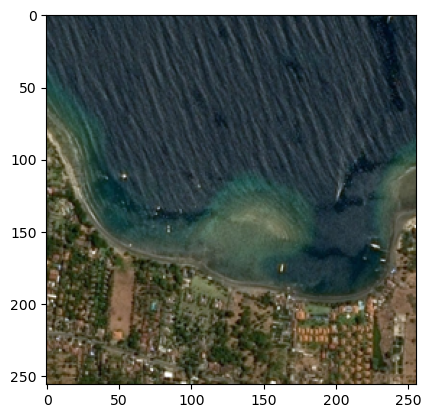

In [8]:
ind = random.randint(0, len(X_train))

plt.imshow(X_train[ind])

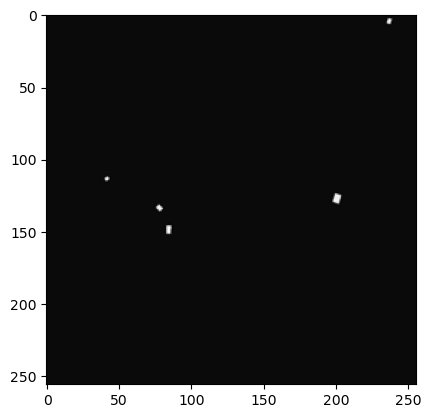

In [9]:
plt.imshow(Y_train[ind], cmap='gray')

In [13]:
history = train(model, X_train, Y_train, epochs=25)

Epoch 1/25
225/225 [==============================] - ETA: 0s - loss: -0.3294 - dice_coef: 0.3294
Epoch 1: val_loss improved from inf to -0.47246, saving model to models\unet-segmentation2023-06-25_09-13-48.h5
225/225 [==============================] - 309s 1s/step - loss: -0.3294 - dice_coef: 0.3294 - val_loss: -0.4725 - val_dice_coef: 0.4749
Epoch 2/25
225/225 [==============================] - ETA: 0s - loss: -0.4816 - dice_coef: 0.4816
Epoch 2: val_loss improved from -0.47246 to -0.54463, saving model to models\unet-segmentation2023-06-25_09-13-48.h5
225/225 [==============================] - 304s 1s/step - loss: -0.4816 - dice_coef: 0.4816 - val_loss: -0.5446 - val_dice_coef: 0.5472
Epoch 3/25
225/225 [==============================] - ETA: 0s - loss: -0.5273 - dice_coef: 0.5273
Epoch 3: val_loss did not improve from -0.54463
225/225 [==============================] - 302s 1s/step - loss: -0.5273 - dice_coef: 0.5273 - val_loss: -0.5367 - val_dice_coef: 0.5396
Epoch 4/25
225/225 [=

In [10]:
X_test, Y_test = fill_ds(test_ids, full_segmentation, TRAIN_FOLDER, img_size=END_IMAGE_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:19<00:00, 25.87it/s]


In [11]:
models_path = 'models/unet-segmentation2023-06-25_09-13-48.h5'

pred = predict(models_path, X_test)

16/16 [==============================] - 8s 445ms/step


In [12]:
loss, dice_score = inference(models_path, X_test, Y_test)
print('Dice loss:', round(loss, 4))
print(f'Dice score: {round(dice_score, 2)*100}%')

16/16 [==============================] - 8s 444ms/step - loss: -0.6680 - dice_coef: 0.6670
Dice loss: -0.668
Dice score: 67.0%


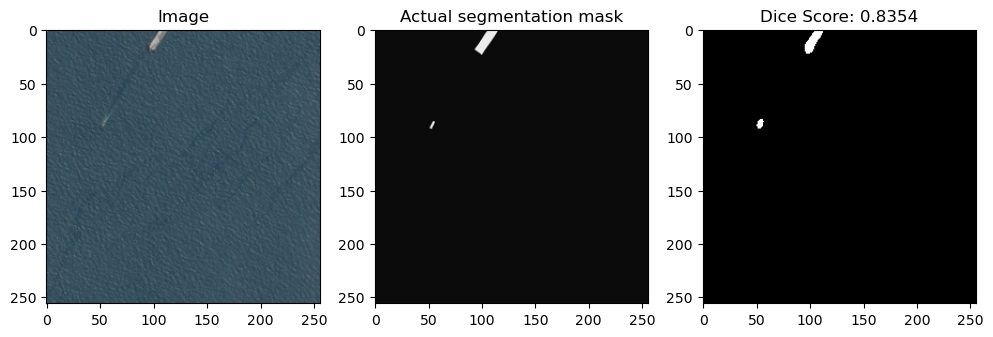

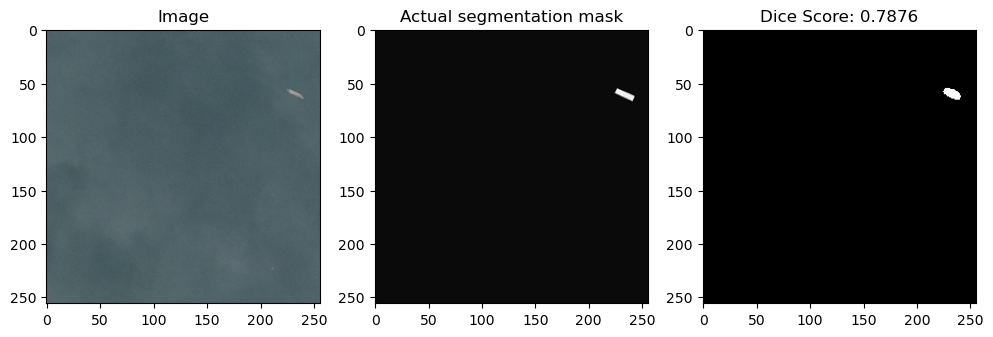

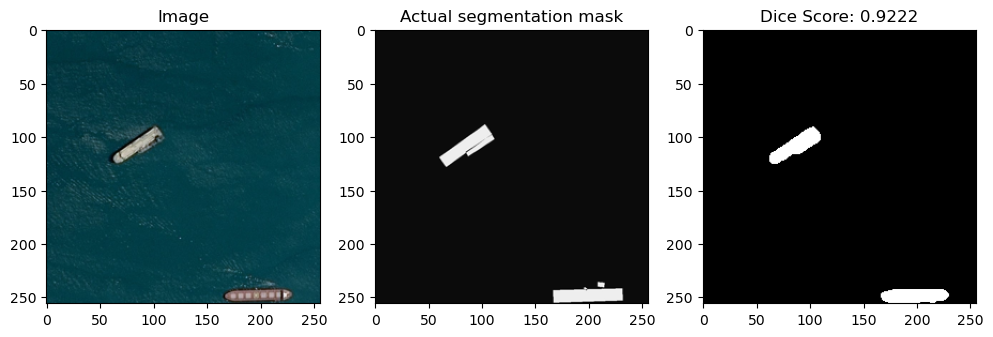

In [15]:
indexes = np.random.choice([_ for _ in range(len(pred))], size=3, replace=False)

for ind in indexes:
    fig, axes = plt.subplots(1, 3)
    fig.set_figheight(16)
    fig.set_figwidth(12)
    
    axes[0].imshow(X_test[ind])
    axes[0].set_title("Image")

    axes[1].imshow(Y_test[ind], cmap='gray')
    axes[1].set_title("Actual segmentation mask")

    dice_score = dice_coef(Y_test[ind], pred[ind])
    axes[2].imshow(pred[ind], cmap='gray')
    axes[2].set_title(f"Dice Score: {dice_score:.4f}")
    
plt.show()